# Analiza średnich temperatur dziennych w Madrycie

średnich temperatur dziennych analiza madrycka

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

## Przygotowanie danych

In [2]:
data_path_madrid = 'madrid.csv'
madrid_data = pd.read_csv(data_path_madrid)

madrid_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Spain,NaN,Madrid,5,13,2017,61.0
1,Europe,Spain,NaN,Madrid,5,14,2017,63.2
2,Europe,Spain,NaN,Madrid,5,15,2017,66.8
3,Europe,Spain,NaN,Madrid,5,16,2017,73.7
4,Europe,Spain,NaN,Madrid,5,17,2017,72.3


Na tym etapie stwierdzamy, że `Region`, `Country` i `State` nie są nam potrzebne

In [3]:
madrid_data = madrid_data.drop('Region', axis=1)
madrid_data = madrid_data.drop('Country', axis=1)
madrid_data = madrid_data.drop('State', axis=1)

madrid_data

,City,Month,Day,Year,AvgTemperature
0,Madrid,5,13,2017,61.0
1,Madrid,5,14,2017,63.2
2,Madrid,5,15,2017,66.8
3,Madrid,5,16,2017,73.7
4,Madrid,5,17,2017,72.3
...,...,...,...,...,...
1092,Madrid,5,9,2020,67.0
1093,Madrid,5,10,2020,60.1
1094,Madrid,5,11,2020,60.6
1095,Madrid,5,12,2020,55.3


`Month`, `Day`, `Year` i `AvgTemperature` to liczby

In [4]:
madrid_data["Month"] = pd.to_numeric(madrid_data["Month"])
madrid_data["Day"] = pd.to_numeric(madrid_data["Day"])
madrid_data["Year"] = pd.to_numeric(madrid_data["Year"])
madrid_data["AvgTemperature"] = pd.to_numeric(madrid_data["AvgTemperature"])

Coś tam z datą 

In [5]:
madrid_data['Date'] = pd.to_datetime(madrid_data[['Year', 'Month', 'Day']])

madrid_data = madrid_data.sort_values(by='Date')

madrid_data

,City,Month,Day,Year,AvgTemperature,Date
0,Madrid,5,13,2017,61.0,2017-05-13
1,Madrid,5,14,2017,63.2,2017-05-14
2,Madrid,5,15,2017,66.8,2017-05-15
3,Madrid,5,16,2017,73.7,2017-05-16
4,Madrid,5,17,2017,72.3,2017-05-17
...,...,...,...,...,...,...
1092,Madrid,5,9,2020,67.0,2020-05-09
1093,Madrid,5,10,2020,60.1,2020-05-10
1094,Madrid,5,11,2020,60.6,2020-05-11
1095,Madrid,5,12,2020,55.3,2020-05-12


Zobaczmy jak dane się prezentują na wykresie

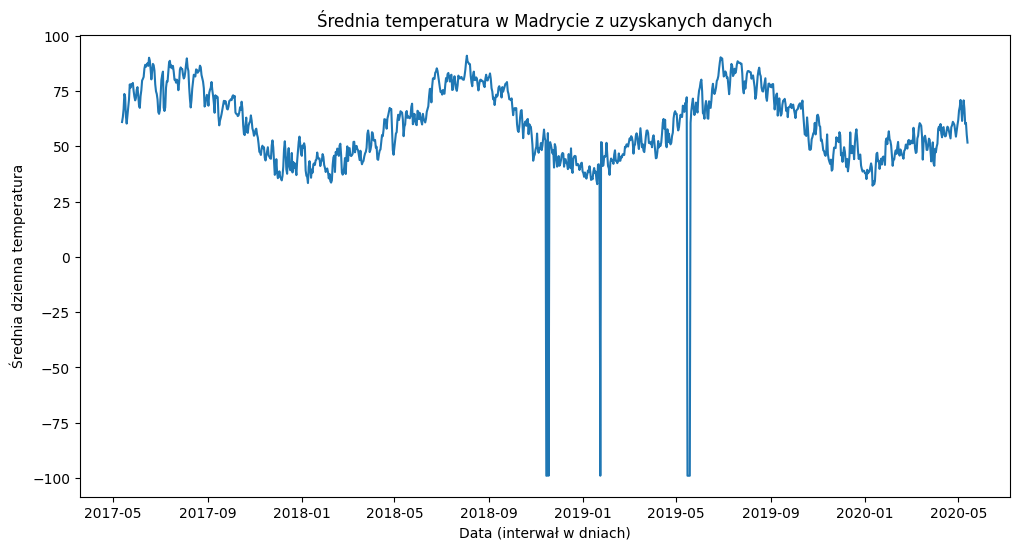

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'])

plt.title('Średnia temperatura w Madrycie z uzyskanych danych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.show()

### Brakujące wartości

Widzimy teraz pewne problemy. W uzyskanych danych badacze nie zmierzeli danych dla wybranych konkretnych przypadkowych dni co powoduje problem.

Dodatkowo temperatura jest prawdopodobnie w Farenheitach 

In [7]:
madrid_data[madrid_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
550,Madrid,11,14,2018,-99.0,2018-11-14
551,Madrid,11,15,2018,-99.0,2018-11-15
553,Madrid,11,17,2018,-99.0,2018-11-17
620,Madrid,1,23,2019,-99.0,2019-01-23
733,Madrid,5,16,2019,-99.0,2019-05-16


hahahhahhahahahhah

Potwierdza się hipoteza, `-99` to wartość kiedy prawdopodobnie temp. nie została zmierzona bo mija się to z prawdą. Zmienimy je na średnią z 5 sasiądujących dni.
`brakujący dzień = 1/4 (-2 dzień + -1 dzień + +1 dzień + +2dzień)`

In [8]:
madrid_data['AvgTemperature_New'] = madrid_data['AvgTemperature']

for i in range(len(madrid_data)):
    if madrid_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(madrid_data), i + 2)
        neighbors = madrid_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        madrid_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

madrid_data['AvgTemperature'] = madrid_data['AvgTemperature_New']
madrid_data = madrid_data.drop('AvgTemperature_New', axis=1)

madrid_data[madrid_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Puste wiersze z złymi danymi => więc się zgadza. 

Zobaczmy wykres po tych modyfikacjach

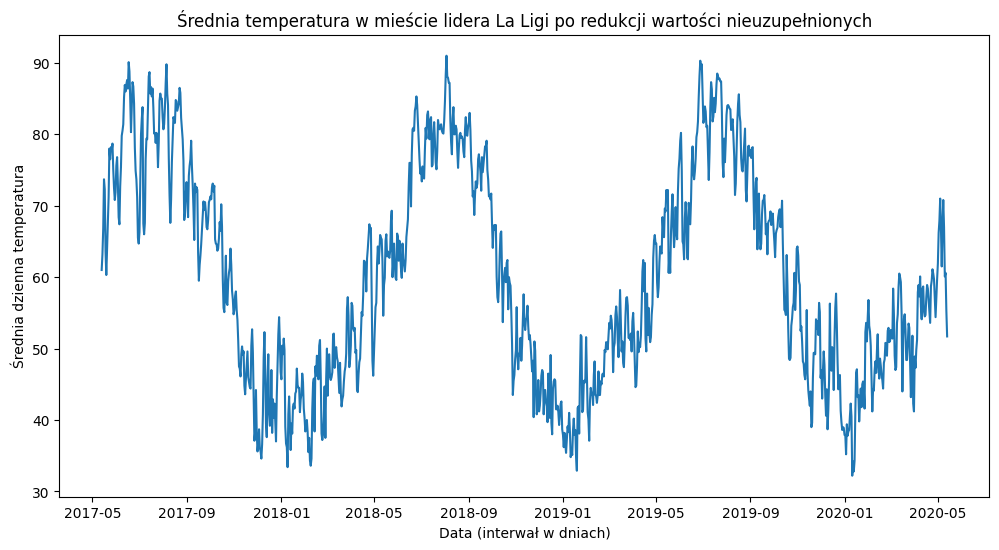

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'])

plt.title('Średnia temperatura w mieście lidera La Ligi po redukcji wartości nieuzupełnionych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.show()

### Konwersja stopni

Wartości są mniej niepokojące, jednak 90 stopni nie jest możliwe. Zauważmy że $100$ stopni Farenheita to $37.7$ Celcjusza co miałoby większy sens ale maksimum.

Wzór konwersji z Farenheita na Celsjusza to:
$$
(F - 32) \cdot \frac{5}{9}
$$

In [10]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * (5/9)


madrid_data['AvgTemperature'] = madrid_data['AvgTemperature'].apply(fahrenheit_to_celsius)

Ponownie spójrzmy na wykres

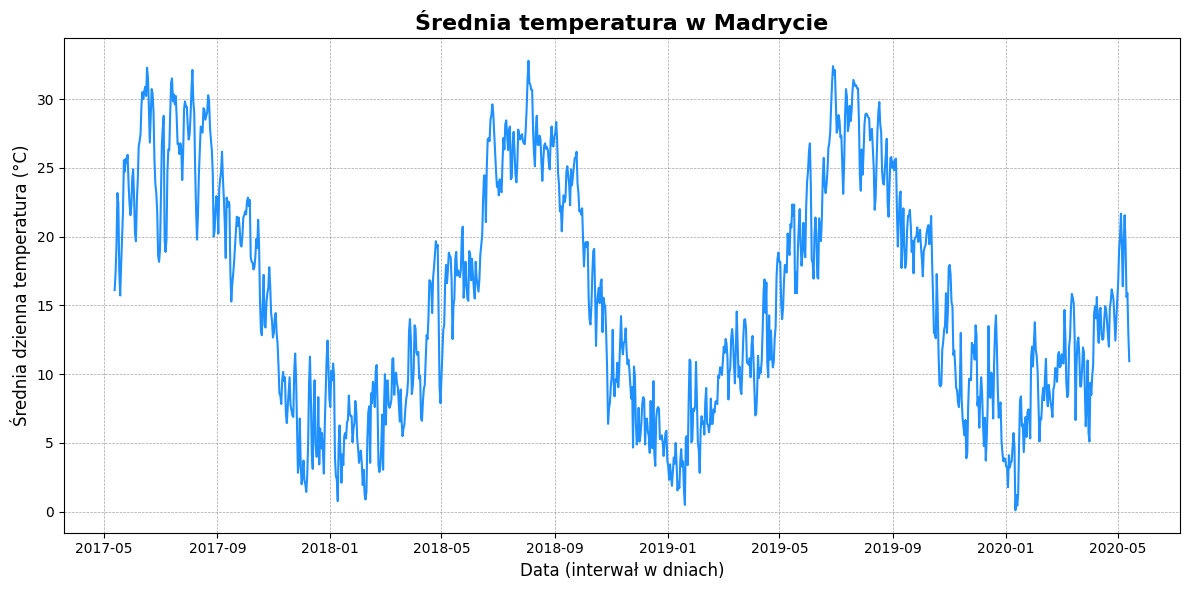

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'], color='dodgerblue', linewidth=1.5)

plt.title('Średnia temperatura w Madrycie', fontsize=16, fontweight='bold')

plt.xlabel('Data (interwał w dniach)', fontsize=12)
plt.ylabel('Średnia dzienna temperatura (°C)', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Takie dane wyglądają jak najbadziej sensownie i realnie - mamy więc z czym pracować.

# Zbadanie jakości danych

Średnia: 15.597412134103108
Odchylenie standardowe: 8.263092461953267
Mediana: 14.666666666666666
Liczba obserwacji: 1097
Minimum: 0.1111111111111127
Maksimum: 32.77777777777778


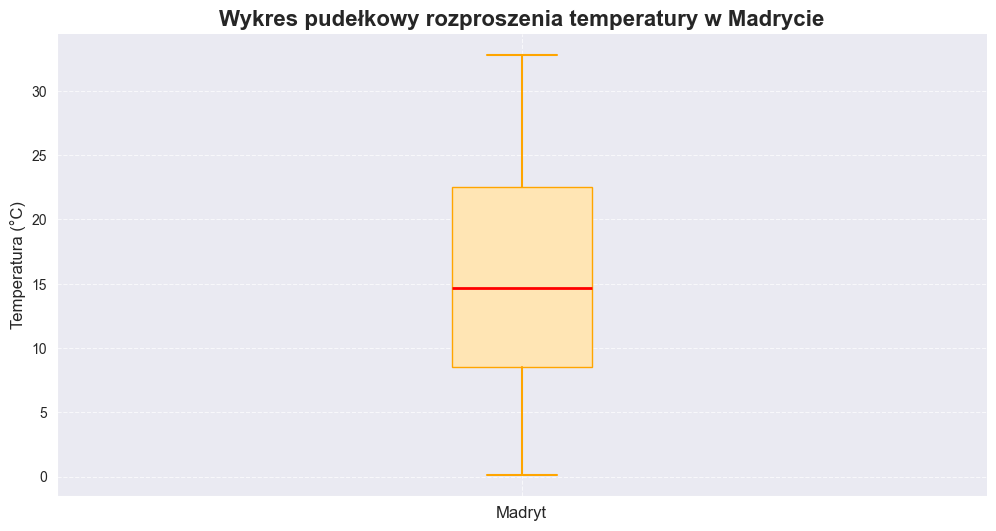

In [75]:
data = madrid_data['AvgTemperature']
srednia = np.mean(data)
odchylenie = np.std(data)
mediana = np.median(data)
ilosc_danych = len(data)
minimum = np.min(data)
maksimum = np.max(data)

print(f"Średnia: {srednia}")
print(f"Odchylenie standardowe: {odchylenie}")
print(f"Mediana: {mediana}")
print(f"Liczba obserwacji: {ilosc_danych}")
print(f"Minimum: {minimum}")
print(f"Maksimum: {maksimum}")


plt.figure(figsize=(12, 6))

box = plt.boxplot(
    data, 
    patch_artist=True, 
    boxprops=dict(facecolor='#ffe5b4', color='orange'), 
    whiskerprops=dict(color='orange', linewidth=1.5), 
    capprops=dict(color='orange', linewidth=1.5), 
    medianprops=dict(color='red', linewidth=2)
)

plt.title('Wykres pudełkowy rozproszenia temperatury w Madrycie', fontsize=16, fontweight='bold')
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(ticks=[1], labels=['Madryt'], fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Autokowariancja i autokorelacja empiryczna dla surowych danych:

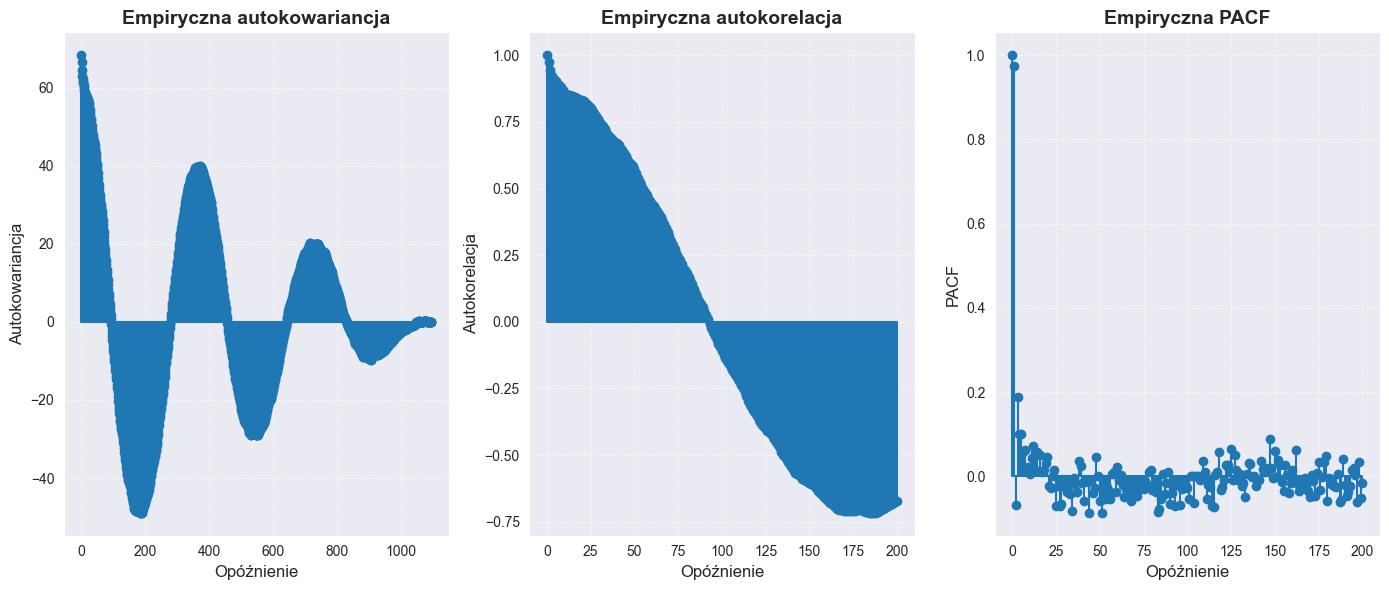

In [84]:
dane_surowe = madrid_data['AvgTemperature']
h_max = 200
acovf_surowe = acovf(dane_surowe, fft=True)
acf_emp_surowe = acf(dane_surowe, fft=True, nlags=h_max)
pacf_emp_surowe = pacf(dane_surowe, nlags = h_max, method='yw')
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.stem(acovf_surowe, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('Autokowariancja',fontsize=12)
plt.title('Empiryczna autokowariancja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')

plt.subplot(1, 3, 2)
plt.stem(acf_emp_surowe, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('Autokorelacja',fontsize=12)
plt.title('Empiryczna autokorelacja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')

plt.subplot(1, 3, 3)
plt.stem(pacf_emp_surowe, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('PACF',fontsize=12)
plt.title('Empiryczna PACF', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')
plt.tight_layout()
plt.show()


Test ADF (Augmented Dickey-Fuller) w celu weryfikacji hipotezy o niestacjonarności danych czasowych

In [59]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [60]:
dane_surowe = madrid_data['AvgTemperature']
adfuller_test(dane_surowe)

Statystyka testowa = -1.939, p-value = 0.314 => Non-stationary.


Interpretacja:
Porównanie ADF Statistic z wartościami krytycznymi:

1. Wartość statystyki  ADF=−1.9393 jest większa (mniej ujemna) niż wszystkie wartości krytyczne (
−3.4364, −2.8642, −2.5682). To sugeruje brak wystarczających dowodów na odrzucenie hipotezy zerowej.
2. p-value:
Wartość p=0.3138 jest większa niż typowy poziom istotności (0.05). Oznacza to, że nie możemy odrzucić hipotezy zerowej o niestacjonarności danych.

Wniosek: Dane są niestacjonarne. Aby móc zastosować model ARMA, należy przekształcić dane, by stały się stacjonarne. I po to kolejne kroki w raporcie.

No i teraz cykamy te metody, zad 4 z L5 bylo podobne do jej kodow i chyba dawalo ten sam efekt, więc bazujmy na jej kodzie do tego.

U niej bylo na sztywno wybrane jakies 0.1*t, wiec u nas musi byc dopasowane do danych, chat tak proponuje.

[10.29442031  0.01731905  0.3263944  -0.03093981]


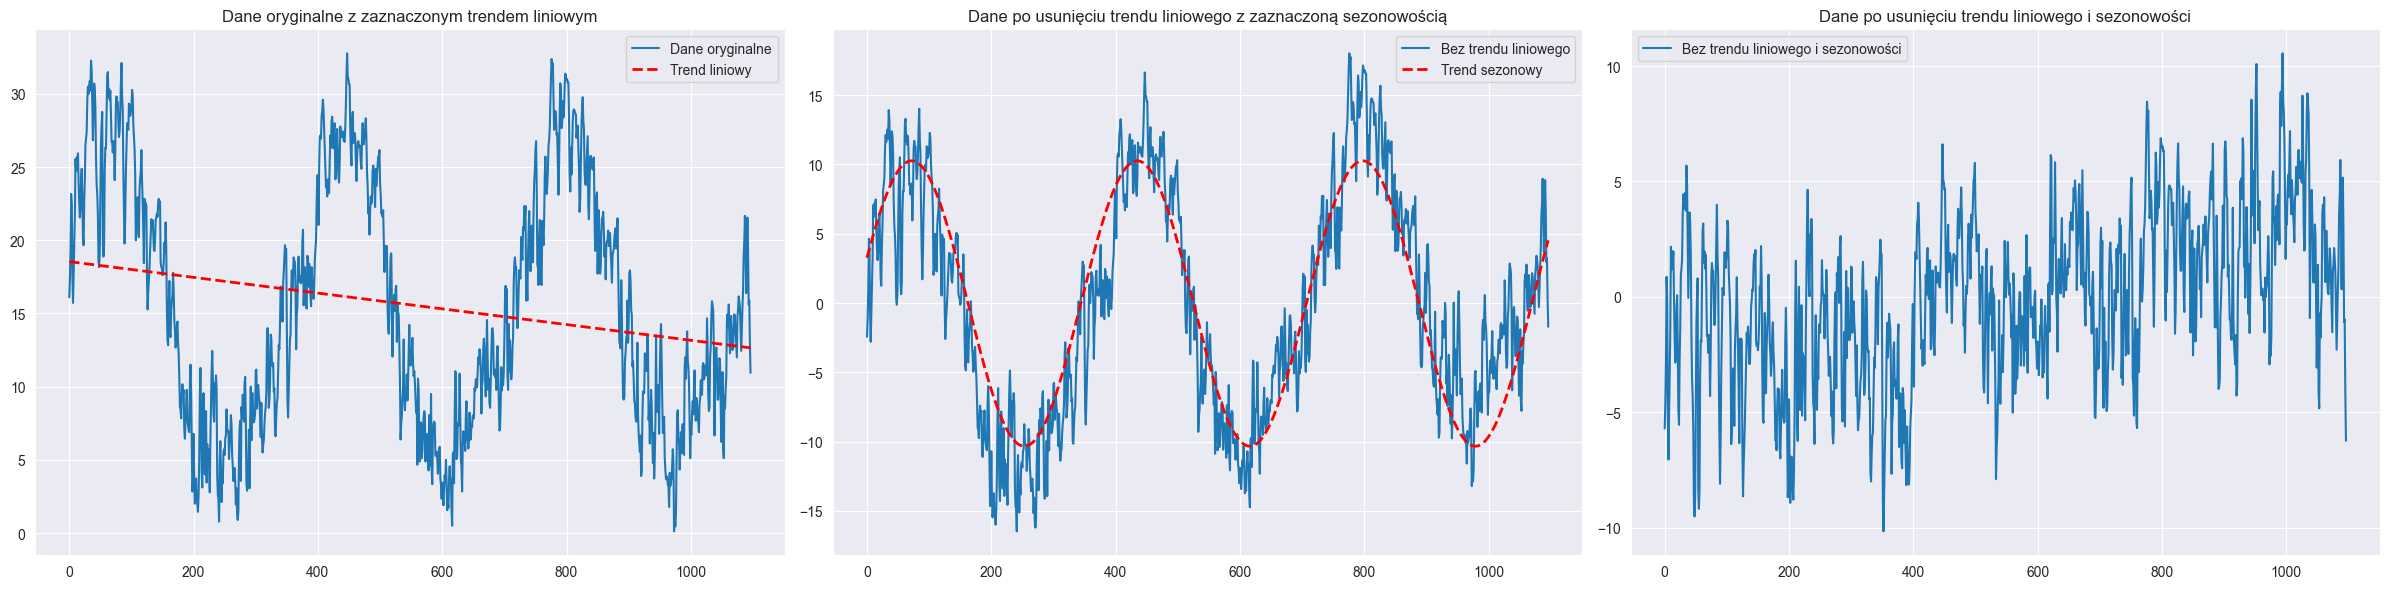

In [94]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
time = np.arange(len(madrid_data))
temperature = madrid_data['AvgTemperature'].values

linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), temperature)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))
temperature_without_linear_trend = temperature - trend_predicted

def sine_func(x, A, omega, phi, offset):
    """
    A       – amplituda
    omega   – częstotliwość (np. 2π/365 dla danych dziennych o rocznej cykliczności)
    phi     – przesunięcie fazowe (w radianach)
    offset  – przesunięcie w pionie (średni poziom)
    """
    return offset + A * np.sin(omega * x + phi)

p0 = [
    10,          # amplituda początkowa
    2 * np.pi/365, # częstotliwość (jeśli dane są dzienne i spodziewamy się roku)
    0,           # faza startowa
    0            # offset (śr. poziom)
]
params, _ = curve_fit(sine_func, time, temperature_without_linear_trend, p0=p0)
print(params)
fitted_sine_wave = sine_func(time, *params)
temperature_without_seasonal = temperature_without_linear_trend - fitted_sine_wave


fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Wykres trendu liniowego
axes[0].plot(madrid_data['AvgTemperature'], label='Dane oryginalne')
axes[0].plot(trend_predicted, label='Trend liniowy', linestyle='--', color = 'red', linewidth = 2)
axes[0].set_title('Dane oryginalne z zaznaczonym trendem liniowym')
axes[0].legend()

axes[1].plot(madrid_data.index, temperature_without_linear_trend, label='Bez trendu liniowego')
axes[1].plot(madrid_data.index, fitted_sine_wave, label='Trend sezonowy', linestyle='--', color = 'red', linewidth = 2)
axes[1].set_title('Dane po usunięciu trendu liniowego z zaznaczoną sezonowością')
axes[1].legend()

axes[2].plot(madrid_data.index, temperature_without_seasonal, label='Bez trendu liniowego i sezonowości')
axes[2].set_title('Dane po usunięciu trendu liniowego i sezonowości')
axes[2].legend()
plt.tight_layout()
plt.show()

## Sprawdzenie adf dla danych po usunieciu trendu i po usunięciu sezonowości:

In [95]:
print('ADF test dla danych bez trendu liniowego (z sezonowością):')
adfuller_test(temperature_without_linear_trend)


dane_bez_sezonowosci = temperature - fitted_sine_wave
print('\nADF test dla danych bez sezonowości (z trendem liniowym):')
adfuller_test(dane_bez_sezonowosci)


ADF test dla danych bez trendu liniowego (z sezonowością):
Statystyka testowa = -1.899, p-value = 0.332 => Non-stationary.

ADF test dla danych bez sezonowości (z trendem liniowym):
Statystyka testowa = -9.949, p-Value = 0.0 => Stationary. 


## Sprawdzenie adf testem po usunięciu trendu i sezonowości:

In [96]:
data_cooked = temperature_without_seasonal

adfuller_test(data_cooked)

Statystyka testowa = -7.083, p-Value = 0.0 => Stationary. 


# Autokowariancja i autokorelacja empiryczna dla przekształconych danych:

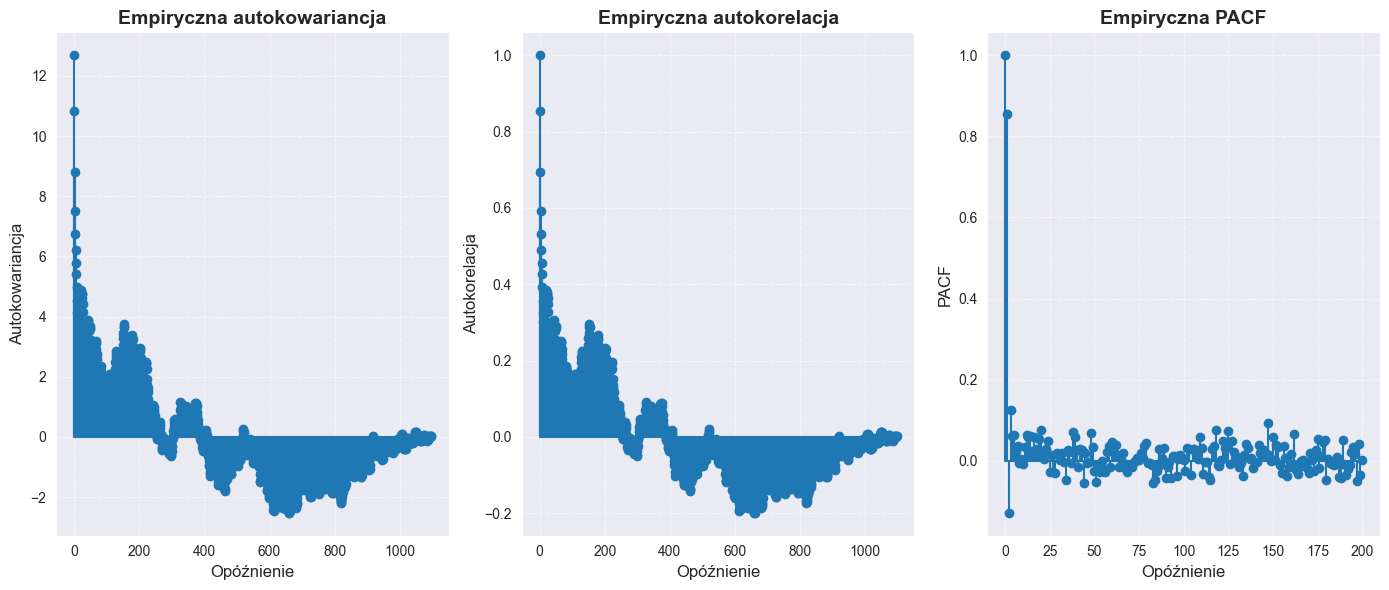

In [98]:
h_max = 200
n = len(data_cooked)
acvf_emp = acovf(data_cooked, fft=True)
acf_emp = acf(data_cooked, fft=True, nlags=n)
pacf_emp = pacf(data_cooked, nlags=h_max, method='yw')

plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.stem(acvf_emp, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('Autokowariancja',fontsize=12)
plt.title('Empiryczna autokowariancja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')

plt.subplot(1, 3, 2)
plt.stem(acf_emp, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('Autokorelacja',fontsize=12)
plt.title('Empiryczna autokorelacja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')

plt.subplot(1, 3, 3)
plt.stem(pacf_emp, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('PACF',fontsize=12)
plt.title('Empiryczna PACF', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')
plt.tight_layout()
plt.show()

# Dopasowanie ARMA

In [101]:
# Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 5
max_q = 5

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(data_cooked, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

df.sort_values(by='AIC').head(1)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

,p,q,AIC,BIC,HQIC
12,2,2,4408.893176,4438.895183,4420.244671


In [102]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,4408.893176,4438.895183,4420.244671


In [103]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,4408.893176,4438.895183,4420.244671


In [104]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Zakładamy, że "temperature_clean" to nasz szereg już bez trendu/niesta­cjo­nar­no­ści,
# np.: temperature_clean = temperature_without_seasonal

lowest_aic = np.inf
best_order = None
best_model = None

# Przykładowy zakres poszukiwań:
p_values = range(0, 5)
q_values = range(0, 5)

for p in p_values:
    for q in q_values:
        try:
            # Dopasowanie ARIMA(p,0,q), czyli de facto ARMA(p,q)
            model = sm.tsa.ARIMA(data_cooked, order=(p, 0, q))
            results = model.fit()

            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_order = (p, q)
                best_model = results
        except:
            # Czasem model może się nie zbiec lub wystąpi inny błąd.
            continue

print("Najlepsze (p,q) wg AIC:", best_order)
print("Najniższy AIC:", lowest_aic)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Najlepsze (p,q) wg AIC: (2, 2)
Najniższy AIC: 4408.8931760106725


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(
    data_cooked,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,                # Ustawiamy d=0, żeby przeszukiwać ARMA(p,q)
    seasonal=False,     # Zakładamy brak sezonowości (ARMA to model niese­zo­no­wy)
    trace=True,         # Wyświetlanie kolejnych testowanych modeli
    stepwise=False,      # Algorytm krokowy
    information_criterion='aic'  # lub 'bic'
)

print(auto_model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5902.261, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5032.695, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4718.046, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4588.774, Time=0.21 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4541.373, Time=0.40 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=4505.549, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4459.194, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4436.329, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4430.116, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4423.667, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4420.479, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4442.048, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4434.531, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4406.913, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4408.807, Time=0.64 sec
 ARIMA(3,0

# Wychodzi na to ze dopasowany model to ARMA(2,2)

In [119]:
p, q = 2, 2
model = ARIMA(data_cooked, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

print('\nWyliczone parametry:')
print(model.params[1:-1])


Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1097
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2198.447
Date:                Tue, 21 Jan 2025   AIC                           4408.893
Time:                        21:13:39   BIC                           4438.895
Sample:                             0   HQIC                          4420.245
                               - 1097                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1246      0.860     -0.145      0.885      -1.811       1.562
ar.L1          1.6526      0.044     37.226      0.000       1.566       1.740
ar.L2         -0.6562      0.043    -15.367 